In [111]:
import h5py
import numpy as np
import random
from tqdm import tqdm
from collections import defaultdict
import pandas as pd

import torch
import torch.nn.functional as F

import h5py
import numpy as np
import random
from tqdm import tqdm


import h5py
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [112]:
random.seed(11)
np.random.seed(11)

In [113]:
input_file = '/mnt/f/hprc/hprc-v1.1-mc-chm13_segments.gfa'
output_file = '/mnt/f/hprc/segments_f.hdf5'

In [114]:
seq_lengths = defaultdict(int)
total_sequences = 0
with open(input_file, 'r') as f:
    for line in f:
        seq = line.strip().split("\t")[2]
        seq_lengths[len(seq)] += 1
        total_sequences += 1

print(f"Total sequences in input file: {total_sequences:,}")

Total sequences in input file: 92,879,580


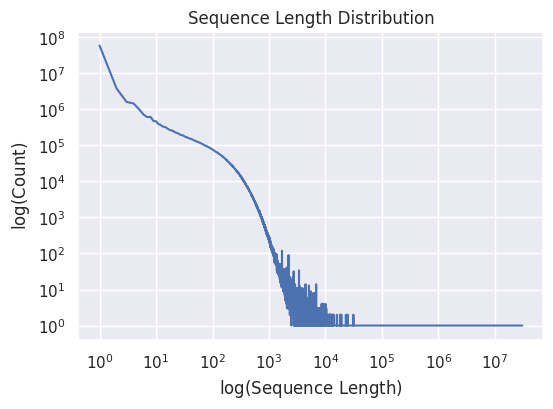

In [115]:
plt.figure(figsize=(6, 4))
ax = sns.lineplot(x=list(seq_lengths.keys()), y=list(seq_lengths.values()))
ax.set_yscale('log')
ax.set_xscale("log")

plt.xlabel(r"${\log (\text{Sequence Length})}$")
plt.ylabel(r"${\log (\text{Count})}$")
plt.title('Sequence Length Distribution')

plt.show()

In [116]:
nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
unknown_nucleotide_index = 4
vocab_size = 5  # 4 nucleotides + 1 unknown ('N')

In [117]:
train_prob = 0.8
val_prob = 0.1
test_prob = 0.1
assert train_prob + val_prob + test_prob == 1.0, "Split probabilities must sum to 1.0"

In [118]:
max_sequences_to_read = 50000

In [119]:
dt = h5py.vlen_dtype(np.uint8)
train_dataset_label = "train"
val_dataset_label = "val"
test_dataset_label = "test"

In [120]:
with h5py.File(output_file, 'w') as hdf5_file:
    sequences_read = 0

    train_count = 0
    val_count = 0
    test_count = 0
    
    train_dataset = hdf5_file.create_dataset(train_dataset_label, shape=(0,), maxshape=(None,), dtype=dt)
    val_dataset = hdf5_file.create_dataset(val_dataset_label, shape=(0,), maxshape=(None,), dtype=dt)
    test_dataset = hdf5_file.create_dataset(test_dataset_label, shape=(0,), maxshape=(None,), dtype=dt)
    
    with open(input_file, 'r') as f:
        for line in tqdm(f, desc="Processing sequences", total=min(total_sequences, max_sequences_to_read)):
            seq = line.strip().split("\t")[2]
            if not seq:
                continue
            
            encoded_seq = np.array(
                [nucleotide_to_index.get(n.upper(), unknown_nucleotide_index) for n in seq],
                dtype=np.uint8
            )
            if len(encoded_seq) == 0:
                continue
            
            rnd_num = random.random()
            if rnd_num < train_prob:
                dataset = train_dataset
                train_count += 1
            elif rnd_num < train_prob + val_prob:
                dataset = val_dataset
                val_count += 1
            else:
                dataset = test_dataset
                test_count += 1
            
            dataset.resize((dataset.shape[0] + 1,))
            dataset[-1] = encoded_seq

            sequences_read += 1
            if sequences_read == max_sequences_to_read:
                break

print(f"Finished processing.")
print(f"\tTrain sequences:\t{train_count:,}\t({(train_count / sequences_read)*100:.2f}%)")
print(f"\tValidation sequences:\t{val_count:,}\t({(val_count / sequences_read)*100:.2f}%)")
print(f"\tTest sequences:\t\t{test_count:,}\t({(test_count / sequences_read)*100:.2f}%)")

Processing sequences: 100%|█████████▉| 49999/50000 [00:02<00:00, 20128.17it/s]


Finished processing.
	Train sequences:	40,020	(80.04%)
	Validation sequences:	4,956	(9.91%)
	Test sequences:		5,024	(10.05%)
